# Demo - Bayesian Neural Network Regression

In [24]:
import numpy as np
from sklearn import datasets
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from transistor_parameter_functions import subthreshold_swing, threshold_voltage, mobility_degradation, R_square
from collections import OrderedDict

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
cuda = torch.device("cuda")

In [27]:
X_train = pd.read_csv("./Train/Design.csv").to_numpy()# .iloc[:1000, :]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
y_train = pd.read_csv("./Train/Character.csv", header=None).iloc[:,1].to_numpy()# .iloc[:1000, :]

X_test = pd.read_csv("./Test/Design.csv").to_numpy()# [VARIABLE]
X_test  = scaler.fit_transform(X_test )
y_test = pd.read_csv("./Test/Character.csv", header=None).iloc[:,1].to_numpy()

(X_train, X_test, y_train, y_test) = tuple(map(lambda x: torch.tensor(x, device=cuda), (X_train, X_test, y_train, y_test)))

## 1. Generate Sample Data

In [28]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(torch.Size([4000, 4]),
 torch.Size([1000, 4]),
 torch.Size([4000]),
 torch.Size([1000]))

In [29]:
#X_train = torch.unsqueeze(X_train, dim=1)
#y_train = torch.unsqueeze(y_train, dim=1)

X_train = X_train.float()
y_train = y_train.float()

In [30]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(torch.Size([4000, 4]),
 torch.Size([1000, 4]),
 torch.Size([4000]),
 torch.Size([1000]))

## 2. Define Model

In [31]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1),
)

model.to("cuda")

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)

In [32]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

## 3. Train Model

In [33]:
kl_weight = 0.1

In [36]:
for step in range(3001):
    pre = model(X_train)
    mse = mse_loss(pre, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if step%300==0:
        print(f'{step}- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

0- MSE : 0.15, KL : 0.15
300- MSE : 0.15, KL : 0.15
600- MSE : 0.15, KL : 0.12
900- MSE : 0.15, KL : 0.13
1200- MSE : 0.15, KL : 0.14
1500- MSE : 0.15, KL : 0.16
1800- MSE : 0.15, KL : 0.11
2100- MSE : 0.15, KL : 0.12
2400- MSE : 0.15, KL : 0.16
2700- MSE : 0.16, KL : 0.15
3000- MSE : 0.15, KL : 0.12


## 4. Test Model

In [8]:
x_test = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3*torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

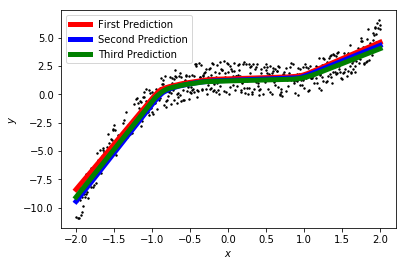

In [9]:
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color='k', s=2) 

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth=5, label='First Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth=5, label='Second Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth=5, label='Third Prediction')

plt.legend()

plt.show()